# Estimate Distribution Parameters

Given $S$, and a biomarker's measurements, how can we estimate $\mathcal N(\theta_{\mu}, \theta_{\sigma})$ and $\mathcal N(\phi_{\mu}, \phi_{\sigma})$?

In [134]:
#| code-fold: false

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import altair as alt 
import math 
from scipy.stats import norm
from copkmeans.cop_kmeans import cop_kmeans
from typing import Dict
import re 
import json 
from collections import defaultdict

In [135]:
output_dir = 'data'
df = pd.read_csv(f"{output_dir}/150|200_3.csv")
biomarkers = df.biomarker.unique()
idx = 1
biomarker_df = df[df.biomarker==biomarkers[idx]]
biomarker_df.sample(10)

,participant,biomarker,measurement,k_j,S_n,affected_or_not,diseased
221,21,PCC-FCI,6.720331,0,2,not_affected,False
208,8,PCC-FCI,10.352851,0,2,not_affected,False
398,198,PCC-FCI,10.198974,0,2,not_affected,False
360,160,PCC-FCI,14.765535,0,2,not_affected,False
318,118,PCC-FCI,13.565672,0,2,not_affected,False
266,66,PCC-FCI,0.444082,8,2,affected,True
329,129,PCC-FCI,14.137447,0,2,not_affected,False
234,34,PCC-FCI,18.188517,0,2,not_affected,False
380,180,PCC-FCI,10.445202,0,2,not_affected,False
244,44,PCC-FCI,6.805627,8,2,affected,True


In [136]:
biomarker_df.shape

(200, 7)

## Constrained K-Means

:::{.callout-tip}

To use this algorithm, we only need to know (1) whether this participant is diseased; and (2) each biomarker measurement.
:::

The first method we can use is constrained K-means, implemented by @behrouz_babaki_2017_831850.

We choose constrained K-Means instead of the standard K-Means algorithm because we know all healthy participants have to belong to the same cluster. The constrained K-Means algorithm can satisfy this constraint. 

In [137]:
#| code-fold: true
def compute_theta_phi_for_biomarker(biomarker_df):
    """get theta and phi parameters for this biomarker using constrained k-means
    input: 
        - biomarker_df: a pd.dataframe of a specific biomarker
    output: 
        - a tuple: theta_mean, theta_std, phi_mean, phi_std
    """
    n_clusters = 2
    measurements = np.array(biomarker_df['measurement']).reshape(-1, 1)
    healthy_df = biomarker_df[biomarker_df['diseased'] == False]
    must_link = [(x, 0) for x in healthy_df.index]
    # imeplement Constrained K-means algorithm
    # https://github.com/Behrouz-Babaki/COP-Kmeans
    clusters, centers = cop_kmeans(dataset=measurements, k=n_clusters, ml=must_link)
    predictions = np.array(clusters)
    healthy_predictions = predictions[healthy_df.index]

    # double check the result
    cluster_counts = np.bincount(predictions)
    if not all(c > 1 for c in cluster_counts):
        raise ValueError(f"Not all clusters have more than one node.")
    if len(cluster_counts) != n_clusters:
        raise ValueError(f"Number of clusters is not equal to {n_clusters}.")
    if len(set(healthy_predictions)) > 1:
        raise ValueError("Not all healthy participants belong to one cluster.")
    
    phi_cluster_idx = healthy_predictions[0]
    theta_cluster_idx = 1 - phi_cluster_idx

    # two empty clusters to strore measurements
    clustered_measurements = [[] for _ in range(2)]
    # Store measurements into their cluster
    for i, prediction in enumerate(predictions):
        clustered_measurements[prediction].append(measurements[i][0])
    
     # Calculate means and standard deviations
    theta_mean, theta_std = np.mean(
        clustered_measurements[theta_cluster_idx]), np.std(
            clustered_measurements[theta_cluster_idx])
    phi_mean, phi_std = np.mean(
        clustered_measurements[phi_cluster_idx]), np.std(
            clustered_measurements[phi_cluster_idx])
    
    # check whether the prior_theta_phi contain 0s or nan
    if math.isnan(theta_std) or theta_std == 0:
        raise ValueError(f"Invalid theta_std: {theta_std}")
    if math.isnan(phi_std) or phi_std == 0:
        raise ValueError(f"Invalid phi_std: {phi_std}")
    if theta_mean == 0 or math.isnan(theta_mean):
        raise ValueError(f"Invalid theta_mean: {theta_mean}")
    if phi_mean == 0 or math.isnan(phi_mean):
        raise ValueError(f"Invalid phi_mean: {phi_mean}")

    return theta_mean, theta_std, phi_mean, phi_std

def get_theta_phi_estimates(
    data: pd.DataFrame,
) -> Dict[str, Dict[str, float]]:
    """
    Obtain theta and phi estimates (mean and standard deviation) for each biomarker.

    Args:
    data (pd.DataFrame): DataFrame containing participant data with columns 'participant', 
        'biomarker', 'measurement', and 'diseased'.
    # biomarkers (List[str]): A list of biomarker names.

    Returns:
    Dict[str, Dict[str, float]]: A dictionary where each key is a biomarker name,
        and each value is another dictionary containing the means and standard deviations 
        for theta and phi of that biomarker, with keys 'theta_mean', 'theta_std', 'phi_mean', 
        and 'phi_std'.
    """
    # empty hashmap of dictionaries to store the estimates
    estimates = {}
    biomarkers = data.biomarker.unique()
    for biomarker in biomarkers:
        # Filter data for the current biomarker
        # reset_index is necessary here because we will use healthy_df.index later
        biomarker_df = data[data['biomarker']
                            == biomarker].reset_index(drop=True)
        theta_mean, theta_std, phi_mean, phi_std = compute_theta_phi_for_biomarker(
            biomarker_df)
        estimates[biomarker] = {
            'theta_mean': theta_mean,
            'theta_std': theta_std,
            'phi_mean': phi_mean,
            'phi_std': phi_std
        }
    return estimates

In [138]:
cop_kmeans_estimates = get_theta_phi_estimates(data = df)
cop_kmeans_estimates_df = pd.DataFrame.from_dict(
    cop_kmeans_estimates, orient='index')
cop_kmeans_estimates_df.reset_index(names = 'biomarker', inplace=True)
cop_kmeans_estimates_df

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,HIP-FCI,-8.587833,5.365053,4.903437,2.008974
1,PCC-FCI,16.330398,0.720160,10.507041,4.427907
2,AB,152.194375,15.344414,252.969562,50.946400
3,P-Tau,-71.767059,15.231429,-23.737466,16.637657
4,MMSE,22.272803,1.624078,28.011392,0.805532
5,ADAS,-20.582091,3.853234,-6.002048,1.487443
6,HIP-GMI,0.793961,0.132461,0.365322,0.226494
7,AVLT-Sum,23.638988,5.848744,42.028039,14.229989
8,FUS-GMI,0.645942,0.019813,0.579887,0.067980
9,FUS-FCI,-19.200644,4.688806,-9.568412,3.003514


In [139]:
with open('files/real_theta_phi.json', 'r') as f:
    truth = json.load(f)
truth_df = pd.DataFrame.from_dict(truth, orient='index')
truth_df.reset_index(names = 'biomarker', inplace=True)
truth_df

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,MMSE,22.0,2.666667,28.0,0.666667
1,ADAS,-20.0,4.000000,-6.0,1.333333
2,AB,150.0,16.666667,250.0,50.000000
3,P-Tau,-50.0,33.333333,-25.0,16.666667
4,HIP-FCI,-5.0,6.666667,5.0,1.666667
5,HIP-GMI,0.3,0.333333,0.4,0.233333
6,AVLT-Sum,20.0,6.666667,40.0,15.000000
7,PCC-FCI,5.0,3.333333,12.0,4.000000
8,FUS-GMI,0.5,0.066667,0.6,0.066667
9,FUS-FCI,-20.0,6.000000,-10.0,3.333333


Now let's compare the results using plots:

In [140]:
#| code-fold: true
def obtain_theta_phi_params(biomarker, estimate_df, truth):
    '''This is to obtain both true and estimated theta and phi params for each biomarker '''
    biomarker_data_est = estimate_df[estimate_df.biomarker == biomarker].reset_index()
    biomarker_data = truth[truth.biomarker == biomarker].reset_index()
    # theta for affected
    theta_mean_est = biomarker_data_est.theta_mean[0]
    theta_std_est = biomarker_data_est.theta_std[0]

    theta_mean = biomarker_data.theta_mean[0]
    theta_std = biomarker_data.theta_std[0]

    # phi for not affected
    phi_mean_est = biomarker_data_est.phi_mean[0]
    phi_std_est = biomarker_data_est.phi_std[0]

    phi_mean = biomarker_data.phi_mean[0]
    phi_std = biomarker_data.phi_std[0]

    return theta_mean, theta_std, theta_mean_est, theta_std_est, phi_mean, phi_std, phi_mean_est, phi_std_est

def make_chart(biomarkers, estimate_df, truth, title):
    alt.renderers.enable('png')
    charts = []
    for biomarker in biomarkers: 
        theta_mean, theta_std, theta_mean_est, theta_std_est, phi_mean, phi_std, phi_mean_est, phi_std_est = obtain_theta_phi_params(
        biomarker, estimate_df, truth)
        mean1, std1 = theta_mean, theta_std
        mean2, std2 = theta_mean_est, theta_std_est

        # Generating points on the x axis
        x_thetas = np.linspace(min(mean1 - 3*std1, mean2 - 3*std2), 
                        max(mean1 + 3*std1, mean2 + 3*std2), 1000)

        # Creating DataFrames for each distribution
        df1 = pd.DataFrame({'x': x_thetas, 'pdf': norm.pdf(x_thetas, mean1, std1), 'Distribution': 'Actual'})
        df2 = pd.DataFrame({'x': x_thetas, 'pdf': norm.pdf(x_thetas, mean2, std2), 'Distribution': 'Estimated'})

        # Combining the DataFrames
        df3 = pd.concat([df1, df2])

        # Altair plot
        chart_theta = alt.Chart(df3).mark_line().encode(
            x='x',
            y='pdf',
            color=alt.Color('Distribution:N', legend=alt.Legend(title="Theta"))
        ).properties(
            title=f'{biomarker}, Theta',
            width=100,
            height=100
            )

        mean1, std1 = phi_mean, phi_std
        mean2, std2 = phi_mean_est, phi_std_est

        # Generating points on the x axis
        x_phis = np.linspace(min(mean1 - 3*std1, mean2 - 3*std2), 
                        max(mean1 + 3*std1, mean2 + 3*std2), 1000)

        # Creating DataFrames for each distribution
        df1 = pd.DataFrame({'x': x_phis, 'pdf': norm.pdf(x_phis, mean1, std1), 'Distribution': 'Actual'})
        df2 = pd.DataFrame({'x': x_phis, 'pdf': norm.pdf(x_phis, mean2, std2), 'Distribution': 'Estimated'})

        # Combining the DataFrames
        df3 = pd.concat([df1, df2])

        # Altair plot
        chart_phi = alt.Chart(df3).mark_line().encode(
            x='x',
            y='pdf',
            color=alt.Color('Distribution:N', legend=alt.Legend(title="Phi"))
        ).properties(
            title=f'{biomarker}, Phi',
            width=100,
            height=100
            )
        
        # Concatenate theta and phi charts horizontally
        hconcat_chart = alt.hconcat(chart_theta, chart_phi).resolve_scale(color="independent")

        # Append the concatenated chart to the list of charts
        charts.append(hconcat_chart)
    # Concatenate all the charts vertically
    final_chart = alt.vconcat(*charts).properties(title = title)

    # Display the final chart
    final_chart.display()

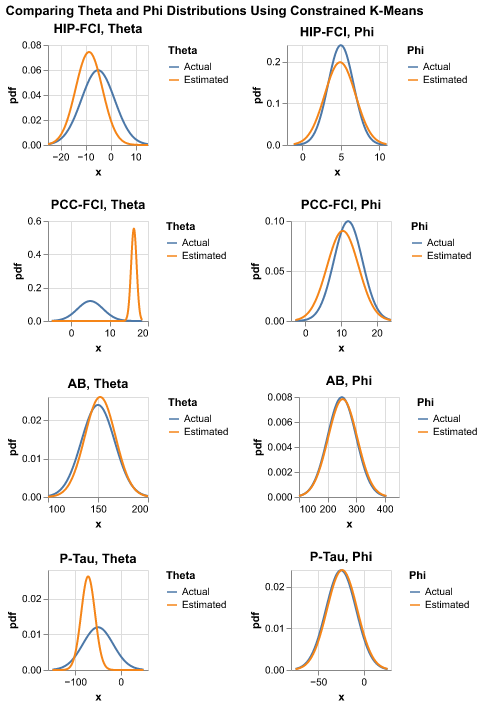

In [141]:
#| fig-cap: Comparing Theta and Phi Distributions Using Constrained K-Means
#| label: fig-estDistParamsCOPKM

make_chart(
    biomarkers[0:4], 
    cop_kmeans_estimates_df, 
    truth_df, 
    title = "Comparing Theta and Phi Distributions Using Constrained K-Means"
)

It turns out the result is not very desriable.  

## Conjugate Priors

The second method we may utilize is conjugate priors. Conjugacy occurs when the posterior distribution is in the same family of distribution as the prior distribution, but with new parameter values. 

Why conjugacy is important? Because without it, one has to do the integration, which oftentimes is hard. 

Three major conjugate families:

- Beta-Binomial
- Gamma-Poisson
- Normal-Normal

In our example, we assume that the measurement data for each biomarker follows a normal distribution; however, we do not know the exact $\mu$ and $\sigma$. Our job is to estimate the two parameters for each biomarker based on the data we have. 

According to [*An Introduction to Bayesian Thinking*](https://statswithr.github.io/book/inference-and-decision-making-with-multiple-parameters.html#sec:normal-gamma) by @clydeintroduction, if the data comes from a normal distribution with unknown $\mu$ and $\sigma$, the conjugate prior for $\mu$ has a normal distribution with mean $m_0$ and variance $\frac{\sigma^2}{n_0}$. The conjugate prior for $\frac{1}{\sigma^2}$ has a Gamma distribution with shape $\frac{v_0}{2}$ and rate $\frac{v_0 s_0^{2}}{2}$ where

- $m_0$: prior estimate of $\mu$.
- $n_0$: how strongly is the prior belief in $m_0$ is held.
- $s_0^2$: prior estimate of $\sigma^2$.
- $v_0$: prior degress of freedome, influencing the certainty of $s_0^2$.

That is to say: 

$$\mu | \sigma^2 \sim \mathcal{N}(m_0, \sigma^2/n_0)$$

$$1/\sigma^2 \sim Gamma\left(\frac{v_0}{2}, \frac{v_0 s_0^2}{2} \right)$$

Combined, we have:

$$(\mu, 1/\sigma^2) \sim NormalGamma(m_0, n_0, s_0^2, v_0)$$

The posterior also follows a Normal-Gamma distribution:

$$(\mu, 1/\sigma^2) | data \sim NormalGamma(m_n, n_n, s_n^2, v_n)$$

More specifically

$$1/\sigma^2 | data \sim Gamma(v_n/2, s_n^2 v_n/2)$$

$$\mu | data, \sigma^2 \sim \mathcal{N}(m_n, \sigma^2/n_n)$$

Based on the above two equations, we know that the mean of posterior mean is $m_n$ and the mean of the posterior variance is $(s_n^2 v_n/2)/(v_n/2)$. This is beceause the expected value of $Gamma(\alpha, \beta)$ is $\frac{\alpha}{\beta}$.

where 

- $m_n$: posterior mean, mode, and median for $\mu$
- $n_n$: posterior sample size 
- $s_n^2$: posterior variance 
- $v_n$: posterior degrees of freedome

The updating rules to get the new hyper-parameters: 

<!-- $$m_n = \frac{n \bar{y} + n_0m_0}{n + n_0}$$ -->

$$m_n = \frac{n}{n+n_0} \bar{y} + \frac{n_0}{n+n_0}m_0$$

$$n_n = n_0 + n$$

$$v_n = v_0 + n$$

$$s_n^2 = \frac{1}{v_n}\left[s^2(n-1) + s_0^2v_0 + \frac{n_0n}{n_n}(\bar{y}-m_0)^2\right]$$

where

- $n$: sample size
- $\bar{y}$: sample mean 
- $s^2$: sample variance

:::{.callout-tip}

To apply the algorithm of conjugate priors, we assume we already know $S$ and $k_j$, alongside biomarker measurement ($X_{nj}$). Based on $S$ and $k_j$, we can infer whether a biomarker is affected by the disease or not. 

:::

In [142]:
#| code-fold: true
def estimate_params_exact(m0, n0, s0_sq, v0, data):
    '''This is to estimate means and vars based on conjugate priors
    Inputs:
        - data: a vector of measurements 
        - m0: prior estimate of $\mu$.
        - n0: how strongly is the prior belief in $m_0$ is held.
        - s0_sq: prior estimate of $\sigma^2$.
        - v0: prior degress of freedome, influencing the certainty of $s_0^2$.

    Outputs:
        - mu estiate, std estimate
    '''
    # Data summary
    sample_mean = np.mean(data)
    sample_size = len(data)
    sample_var = np.var(data, ddof=1)  # ddof=1 for unbiased estimator

    # Update hyperparameters for the Normal-Inverse Gamma posterior
    updated_m0 = (n0 * m0 + sample_size * sample_mean) / (n0 + sample_size)
    updated_n0 = n0 + sample_size
    updated_v0 = v0 + sample_size
    updated_s0_sq = (1 / updated_v0) * ((sample_size - 1) * sample_var + v0 * s0_sq +
                                        (n0 * sample_size / updated_n0) * (sample_mean - m0)**2)
    updated_alpha = updated_v0/2
    updated_beta = updated_v0*updated_s0_sq/2

    # Posterior estimates
    mu_posterior_mean = updated_m0
    sigma_squared_posterior_mean = updated_beta/updated_alpha

    mu_estimation = mu_posterior_mean
    std_estimation = np.sqrt(sigma_squared_posterior_mean)

    return mu_estimation, std_estimation

def get_theta_phi_conjugate_priors(biomarkers, data_we_have, theta_phi_kmeans):
    '''To get estimated parameters, returns a hashmap
    Input:
    - biomarkers: biomarkers 
    - data_we_have: participants data filled with initial or updated participant_stages
    - theta_phi_kmeans: a hashmap of dicts, which are the prior theta and phi values
        obtained from the initial constrained kmeans algorithm

    Output: 
    - a hashmap of dictionaries. Key is biomarker name and value is a dictionary.
    Each dictionary contains the theta and phi mean/std values for a specific biomarker. 
    '''
    # empty list of dictionaries to store the estimates
    hashmap_of_means_stds_estimate_dicts = {}

    for biomarker in biomarkers:
        # Initialize dictionary outside the inner loop
        dic = {'biomarker': biomarker}
        for affected in ['affected', 'not_affected']:
            data_full = data_we_have[(data_we_have.biomarker == biomarker) & (
                data_we_have.affected_or_not == affected)]
            if len(data_full) > 1:
                measurements = data_full.measurement
                s0_sq = np.var(measurements, ddof=1)
                m0 = np.mean(measurements)
                mu_estimate, std_estimate = estimate_params_exact(
                    m0=m0, n0=1, s0_sq=s0_sq, v0=1, data=measurements)
                if affected == 'affected':
                    dic['theta_mean'] = mu_estimate
                    dic['theta_std'] = std_estimate
                else:
                    dic['phi_mean'] = mu_estimate
                    dic['phi_std'] = std_estimate
            # If there is only one observation or not observation at all, resort to theta_phi_kmeans
            # YES, IT IS POSSIBLE THAT DATA_FULL HERE IS NULL
            # For example, if a biomarker indicates stage of (num_biomarkers), but all participants' stages
            # are smaller than that stage; so that for all participants, this biomarker is not affected
            else:
                print('not enough data here, so we have to use theta phi estimates from constrained kmeans')
                # print(theta_phi_kmeans)
                if affected == 'affected':
                    dic['theta_mean'] = theta_phi_kmeans[biomarker]['theta_mean']
                    dic['theta_std'] = theta_phi_kmeans[biomarker]['theta_std']
                else:
                    dic['phi_mean'] = theta_phi_kmeans[biomarker]['phi_mean']
                    dic['phi_std'] = theta_phi_kmeans[biomarker]['phi_std']
        # print(f"biomarker {biomarker} done!")
        hashmap_of_means_stds_estimate_dicts[biomarker] = dic
    return hashmap_of_means_stds_estimate_dicts

In [143]:
conjugate_prior_theta_phi = get_theta_phi_conjugate_priors(
    biomarkers = biomarkers, 
    data_we_have = df, 
    theta_phi_kmeans = cop_kmeans_estimates
)
cp_df = pd.DataFrame.from_dict(conjugate_prior_theta_phi, orient='index')
cp_df.reset_index(drop=True, inplace=True)
cp_df

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,HIP-FCI,-5.378366,7.233991,5.092800,1.514402
1,PCC-FCI,5.521792,2.777207,12.071769,3.671679
2,AB,151.143708,14.806694,251.973564,51.382188
3,P-Tau,-41.768257,34.857945,-24.739527,14.928907
4,MMSE,23.122406,2.446874,28.049683,0.718493
5,ADAS,-19.633304,4.582900,-5.902198,1.278311
6,HIP-GMI,0.425625,0.272876,0.379542,0.235348
7,AVLT-Sum,21.664360,3.755735,40.700638,14.480463
8,FUS-GMI,0.482745,0.055585,0.590434,0.063730
9,FUS-FCI,-18.566905,5.781937,-9.648705,3.099195


:::{.callout-note}

When we estimate $\theta$ and $\phi$ using conjugate priors, we need to use the result from constrained kmeans as a fall back because it is possible that for a specific biomarker, either the `affected` or the `not_affected` group is empty. If that is the case, we are not able to estimate relevant parameters and have to resort to the fallback result. 

:::

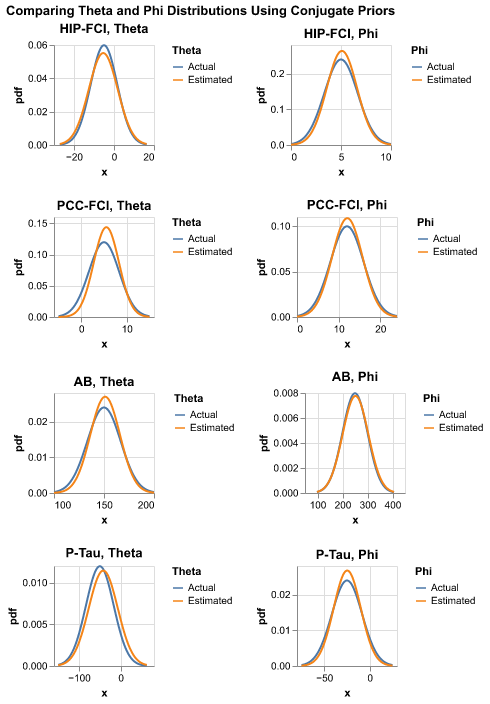

In [144]:
#| fig-cap: Comparing Theta and Phi Distributions Using Conjugate Prior
#| label: fig-estDistParamsCP
make_chart(
    biomarkers[0:4], 
    cp_df, 
    truth_df, 
    title = "Comparing Theta and Phi Distributions Using Conjugate Priors"
)

<!-- ## Conclusion

The result from conjugate priors looks better than that from constrained kmeans. However, to use conjugate priors, we assume that we know $S$ and $k_j$ for each participant, which are very hardly known. The constrained kmeans algorithm does not require any prior knowledge of $S$ nor $k_j$. -->

## Soft K-Means

Conjugate Priors assumes we know $k_j$, which often times is not already known. Constrained K-Means is only taking advantage of $X_{nj}$ and whether participants are diseased or not, leaving $S$, which is known to us, unexploited. 

Soft K-Means is a good alternative to these two because it utilizes $S$ while at the same time not assuming we know $k_j$.

The logic of soft-kmeans is this;

1. If a participant is diseased, we iterate through all possible disease stages, and calculate the associated likelihood using @eq-known-kj. We then normalize these likelihoods to obtain the estimated probability of this participant being at each stage. For example, if there are three possible stages, and the associated likelihoods are `[1, 3, 6]`, then the normalized likelihoods would be `[0.1, 0.3, 0.6]`.

::: {.callout-tip}

You may wonder how we can use @eq-known-kj when we do not know $\theta$ and $\phi$ yet (which is exactly what we are trying to do!). If you notice this, it is a very keen observation!.

If fact, we are going to use the estimated $\theta$ and $\phi$ we obtained above using constrained K-Means. 

:::

2. For each biomarker $n$, we obtain $S_n$ based on $S$. Then we iterate through all participants. If this participant is healthy, we include their biomarker measurement in `cluster_phi`. If this participant is diseased, we compare between $P_{\theta}$ and $P_{\phi}$. If $S_n = 2$, then $P_{\theta} = 0.1 + 0.3 = 0.4$ and $P_{\phi} = 0.6$. Because $P_{\phi}$ is larger, we include this participant's biomarker measurement in `cluster_phi`. When the iteration through participants is done, we can calculate the mean and standard deviation of each cluster. 

::: {.callout-tip}

If  $P_{\theta} =  P_{\phi}$, we randomly assign this participant's biomarker measurement to a cluster. 

:::

In [145]:
#| code-fold: true

def compute_single_measurement_likelihood(theta_phi, biomarker, affected, measurement):
    '''Computes the likelihood of the measurement value of a single biomarker

    We know the normal distribution defined by either theta or phi
    and we know the measurement. This will give us the probability
    of this given measurement value. 

    input:
    - theta_phi: the dictionary containing theta and phi values for each biomarker
    - biomarker: an integer between 0 and 9 
    - affected: boolean 
    - measurement: the observed value for a biomarker in a specific participant

    output: a scalar
    '''
    biomarker_dict = theta_phi[biomarker]
    mu = biomarker_dict['theta_mean'] if affected else biomarker_dict['phi_mean']
    std = biomarker_dict['theta_std'] if affected else biomarker_dict['phi_std']
    var = std**2
    if var <= int(0) or np.isnan(measurement) or np.isnan(mu):
        print(f"Invalid values: measurement: {measurement}, mu: {mu}, var: {var}")
        likelihood = np.exp(-(measurement - mu)**2 /
                            (2 * var)) / np.sqrt(2 * np.pi * var)
    else:
        likelihood = np.exp(-(measurement - mu)**2 /
                            (2 * var)) / np.sqrt(2 * np.pi * var)
    return likelihood

def fill_up_kj_and_affected(pdata, k_j):
    '''Fill up a single participant's data using k_j; basically add two columns: 
    k_j and affected
    Note that this function assumes that pdata already has the S_n column

    Input:
    - pdata: a dataframe of ten biomarker values for a specific participant 
    - k_j: a scalar
    '''
    data = pdata.copy()
    data['k_j'] = k_j
    data['affected'] = data.apply(lambda row: row.k_j >= row.S_n, axis=1)
    return data

def compute_likelihood(pdata, k_j, theta_phi):
    '''
    This function computes the likelihood of seeing this sequence of biomarker values 
    for a specific participant, assuming that this participant is at stage k_j
    '''
    data = fill_up_kj_and_affected(pdata, k_j)
    likelihood = 1
    for i, row in data.iterrows():
        biomarker = row['biomarker']
        measurement = row['measurement']
        affected = row['affected']
        likelihood *= compute_single_measurement_likelihood(
            theta_phi, biomarker, affected, measurement)
    return likelihood

def obtain_participants_hashmap(
        data, 
        prior_theta_phi_estimates,
):
    """
    Input:
        - data: a pd.dataframe. For exrample, 150|200_3.csv
        - prior_theta_phi_estimates, a hashmap of dicts. 
            This is the result from constrained kmeans 
    
    Output: 
        - hashmap: a dictionary whose key is participant id
            and value value is a dict whose key is stage 
            and value is normalized likelihood
    """
    # initialize hashmap_of_normalized_stage_likelihood_dicts
    participants_hashmap = {}
    non_diseased_participants = data[
        data.diseased == False]['participant'].unique()
    disease_stages = data.S_n.unique()
    for p in data.participant.unique():
        dic = defaultdict(int)
        pdata = data[data.participant == p].reset_index(drop = True)
        if p in non_diseased_participants:
            dic[0] = 1
        else:
            for k_j in disease_stages:
                kj_ll = compute_likelihood(pdata, k_j, prior_theta_phi_estimates)
                dic[k_j] = kj_ll
            # likelihood sum
            sum_ll = sum(dic.values())
            epsilon = 1e-10
            if sum_ll == 0:
                sum_ll = epsilon
            normalized_lls = [l/sum_ll for l in dic.values()]
            normalized_ll_dict = dict(zip(disease_stages, normalized_lls))
            participants_hashmap[p] = normalized_ll_dict
    return participants_hashmap 

def calc_soft_kmeans_for_biomarker(
        data,
        biomarker,
        participants_hashmap

):
    """obtain theta, phi estimates using soft kmeans for a single biomarker
    Inputs:
        - data: a pd.dataframe. For example, 150|200_3.csv
        - biomarker: a str, a certain biomarker name
        - hashmap: a dict, returned result of obtain_hashmap()
    Outputs:
        - theta_mean, theta_std, phi_mean, phi_std, a tuple of floats
    """
    non_diseased_participants = data[
        data.diseased == False]['participant'].unique()
    disease_stages = data.S_n.unique()
     # DataFrame for this biomarker
    biomarker_df = data[
        data['biomarker'] == biomarker].reset_index(
            drop=True).sort_values(
                by = 'participant', ascending = True)
    # Extract measurements
    measurements = np.array(biomarker_df['measurement'])

    this_biomarker_order = biomarker_df.S_n[0]

    affected_cluster = []
    non_affected_cluster = []

    for p in data.participant.unique():
        if p in non_diseased_participants:
            non_affected_cluster.append(measurements[p])
        else:
            normalized_ll_dict = participants_hashmap[p]
            affected_prob = sum(
                normalized_ll_dict[
                    kj] for kj in disease_stages if kj >= this_biomarker_order)
            non_affected_prob = sum(
                normalized_ll_dict[
                    kj] for kj in disease_stages if kj < this_biomarker_order)
            if affected_prob > non_affected_prob:
                    affected_cluster.append(measurements[p])
            elif affected_prob < non_affected_prob:
                non_affected_cluster.append(measurements[p])
            else:
                # Assign to either cluster randomly if probabilities are equal
                if np.random.random() > 0.5:
                    affected_cluster.append(measurements[p])
                else:
                    non_affected_cluster.append(measurements[p])
    # Compute means and standard deviations
    theta_mean = np.mean(affected_cluster) if affected_cluster else np.nan
    theta_std = np.std(affected_cluster) if affected_cluster else np.nan
    phi_mean = np.mean(
        non_affected_cluster) if non_affected_cluster else np.nan
    phi_std = np.std(non_affected_cluster) if non_affected_cluster else np.nan
    return theta_mean, theta_std, phi_mean, phi_std

def cal_soft_kmeans_for_biomarkers(
        data,
        participants_hashmap,
        prior_theta_phi_estimates,
):
    soft_kmeans_estimates = {}
    biomarkers = data.biomarker.unique()
    for biomarker in biomarkers:
        dic = {'biomarker': biomarker}
        prior = prior_theta_phi_estimates[biomarker]
        theta_mean, theta_std, phi_mean, phi_std = calc_soft_kmeans_for_biomarker(
            data, biomarker, participants_hashmap
        )
        if theta_std == 0 or math.isnan(theta_std):
            theta_mean = prior['theta_mean']
            theta_std = prior['theta_std']
        if phi_std == 0 or math.isnan(phi_std):
            phi_mean = prior['phi_mean']
            phi_std = prior['phi_std']
        dic['theta_mean'] = theta_mean
        dic['theta_std'] = theta_std
        dic['phi_mean'] = phi_mean
        dic['phi_std'] = phi_std
        soft_kmeans_estimates[biomarker] = dic
    return soft_kmeans_estimates

In [146]:
participants_hashmap = obtain_participants_hashmap(
    data = df, 
    prior_theta_phi_estimates = cop_kmeans_estimates,
)

soft_kmeans_estimates = cal_soft_kmeans_for_biomarkers(
        data = df,
        participants_hashmap = participants_hashmap,
        prior_theta_phi_estimates = cop_kmeans_estimates,
)

In [147]:
soft_kmeans_estimates_df = pd.DataFrame.from_dict(
    soft_kmeans_estimates, orient='index')
soft_kmeans_estimates_df.reset_index(drop=True, inplace=True)
soft_kmeans_estimates_df

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,HIP-FCI,-5.378366,7.232544,5.092800,1.514369
1,PCC-FCI,10.397606,3.698129,10.572261,4.472485
2,AB,157.514640,19.654237,232.546088,61.426283
3,P-Tau,-61.280491,21.704315,-27.032696,20.645375
4,MMSE,21.478486,0.869996,27.414771,1.956947
5,ADAS,-23.386222,3.249392,-7.343264,4.453207
6,HIP-GMI,0.636480,0.017335,0.382067,0.240018
7,AVLT-Sum,23.638988,5.848744,39.259784,14.847938
8,FUS-GMI,0.645942,0.019813,0.584511,0.067892
9,FUS-FCI,-19.200644,4.688806,-10.050024,3.751844


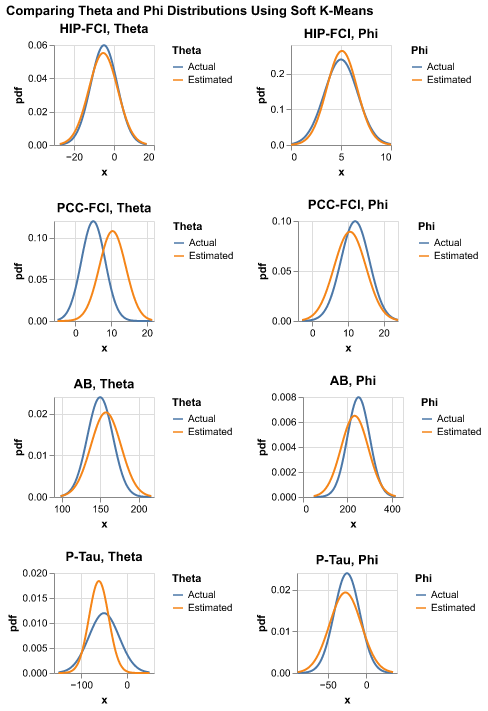

In [148]:
#| fig-cap: Comparing Theta and Phi Distributions Using Soft K-Mean
#| label: fig-estDistParamsSKM
make_chart(
    biomarkers[0:4], 
    soft_kmeans_estimates_df, 
    truth_df, 
    title = "Comparing Theta and Phi Distributions Using Soft K-Means"
)

## Conclusion

We compare the above three methods. Constrained k-means has the least number of prerequisites: it only needs to know whether participants are healthy or not and biomarker measurements. However, the drawback is that it might be very accurate. Conjugate priors are extremely accurate; however, it requires that we know almost everything: besides what is required by constrained k-kmeans, it also needs to know $S$ and $k_j$. Soft k-kmeans does not require the knowledge of $k_j$ and is an improvement over constrained k-means. 

We also noticed that both conjugate priors and soft k-means need the result from constrained k-means as a fallback. 